In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

def extract_AHA_dataset(year):
        aha_df = pd.read_excel("./data/input_data/African_Hydropower_Atlas_v2-0_PoliTechM.xlsx", sheet_name='6 - Inputs code and GIS')
        aha_df['Country'] = aha_df['Country'].map(lambda x: x.lower())
        countrycode_df = pd.read_csv('./data/input_data/countrycode.csv')
        countrycode_df['Country Name'] = countrycode_df['Country Name'].map(lambda x: x.lower())
        aha_df = aha_df.merge(countrycode_df, left_on='Country', right_on='Country Name', how='inner')
        aha_df['COUNTRY'] = aha_df['Country code']
        
        aha_df = aha_df[(aha_df['First Year'] <= year) & (aha_df['First Year'] >= year - 100)]
        aha_df = aha_df[['COUNTRY', 'Capacity', 'Size Type']]
        aha_df = aha_df.groupby(['COUNTRY', 'Size Type'], as_index=False).agg({'Capacity': 'sum'})
        
        aha_df['TECH'] = aha_df['Size Type'].map({'Large': 'HYDMS03X', 'Middle': 'HYDMS02X', 'Small': 'HYDMS01X'})

        if aha_df['TECH'].isna().any():
            raise ValueError("NaN values found in TECHNOLOGY column")
        
        aha_df['Capacity'] = aha_df['Capacity'] / 1000 # GW
        aha_df['TECHNOLOGY'] = aha_df['COUNTRY'] + aha_df['TECH']
        aha_df.drop(columns=['Size Type', 'TECH'], inplace=True)
        return aha_df

def convert_fromGW_capacity_unit(data, unit):
    if unit == 'GW':
        data = data
    elif unit == 'MW':
        data = data * 1000
    else:
        raise ValueError("Unit must be 'GW' or 'MW'")
    return data

def extract_minimum_installed_capacity(year, data_file_path=None, unit='GW'):
    aha_df = extract_AHA_dataset(year)
    residualCapacity_df = pd.read_excel(data_file_path, sheet_name="ResidualCapacity")
    residualCapacity_df['COUNTRY'] = residualCapacity_df['TECHNOLOGY'].map(lambda x: x[:2])
    residualCapacity_df['TECH'] = residualCapacity_df['TECHNOLOGY'].map(lambda x: x[2:])
    new_df = residualCapacity_df[['COUNTRY', 'TECHNOLOGY', year]].rename(columns={year: 'MIN_INSTALLED_CAPACITY'})
    new_df['MIN_INSTALLED_CAPACITY'] = pd.to_numeric(new_df['MIN_INSTALLED_CAPACITY'], errors='coerce')

    new_df = new_df.merge(aha_df, left_on=['COUNTRY', 'TECHNOLOGY'], right_on=['COUNTRY', 'TECHNOLOGY'], how='left')
    new_df['MIN_INSTALLED_CAPACITY'] = new_df['MIN_INSTALLED_CAPACITY'] + new_df['Capacity'].fillna(0)
    new_df.drop(columns=['Capacity'], inplace=True)
    
    new_df['MIN_INSTALLED_CAPACITY'] = convert_fromGW_capacity_unit(new_df['MIN_INSTALLED_CAPACITY'], unit)

    return new_df

def extract_specified_annual_demand(year, data_file_path):
    #Assuming that we are interesting only to the electricity demand
    specified_annual_demand_df = pd.read_excel(data_file_path, sheet_name="SpecifiedAnnualDemand")
    specified_annual_demand_df['COUNTRY'] = specified_annual_demand_df['FUEL'].map(lambda x: x[:2])
    specified_annual_demand_df['FUEL_NAME'] = specified_annual_demand_df['FUEL'].map(lambda x: x[2:])

    new_df = specified_annual_demand_df[['COUNTRY', 'FUEL_NAME', year]].rename(columns={year: 'SPECIFIED_ANNUAL_DEMAND'})
    new_df['SPECIFIED_ANNUAL_DEMAND'] = pd.to_numeric(new_df['SPECIFIED_ANNUAL_DEMAND'], errors='coerce')
    new_df = new_df[new_df['FUEL_NAME'] == 'EL03']
    new_df.drop(columns=['FUEL_NAME'], inplace=True)

    return new_df

def extract_specified_demand_profile(year, timeslices, data_file_path):
    specifiedDemandProfile_df = pd.read_excel(data_file_path, sheet_name="SpecifiedDemandProfile")
    specifiedDemandProfile_df['COUNTRY'] = specifiedDemandProfile_df['FUEL'].map(lambda x: x[:2])
    specifiedDemandProfile_df['FUEL_NAME'] = specifiedDemandProfile_df['FUEL'].map(lambda x: x[2:])

    new_df = specifiedDemandProfile_df[['COUNTRY', 'FUEL_NAME', 'TIMESLICE', year]].rename(columns={year: 'SPECIFIED_DEMAND_PROFILE'})
    new_df['SPECIFIED_DEMAND_PROFILE'] = pd.to_numeric(new_df['SPECIFIED_DEMAND_PROFILE'], errors='coerce')

    if not timeslices:
        # Select only numeric columns before applying sum
        numeric_cols = ['SPECIFIED_DEMAND_PROFILE']
        new_df = new_df.groupby(['COUNTRY', 'FUEL_NAME'], as_index=False)[numeric_cols].sum()

    return new_df

def extract_year_split(year, data_file_path):
    year_split_df = pd.read_excel(data_file_path, sheet_name="YearSplit")
    year_split_df.rename(columns={'Unnamed: 0': 'TIMESLICE'}, inplace=True)

    new_df = year_split_df[['TIMESLICE', year]].rename(columns={year: 'YEAR_SPLIT'})
    return new_df


year = 2030
data_file_path = "data/input_data/TEMBA_SSP4-60.xlsx"
solution_path = 'solutions/SAPP-single-country-limited-technology-2030/combined_solution.xml'
countries =  ['AO', 'BW', 'CD', 'LS', 'MW', 'MZ', 'NM', 'SZ', 'TZ', 'ZA', 'ZM', 'ZW']
rows = 4
cols = 3



In [2]:
residuals_df = extract_minimum_installed_capacity(year=2030, data_file_path=data_file_path, unit='MW')
residuals_df['TECH'] = residuals_df['TECHNOLOGY'].map(lambda x: x[2:])
residuals_df = residuals_df[residuals_df['COUNTRY'].isin(countries)]
residuals_df.drop(columns=['TECHNOLOGY'], inplace=True)


In [3]:
demand_df = extract_specified_annual_demand(year=2030, data_file_path=data_file_path)
demand_df['SPECIFIED_ANNUAL_DEMAND'] = demand_df['SPECIFIED_ANNUAL_DEMAND'] * 1000

specified_df = extract_specified_demand_profile(year=2030, timeslices=True, data_file_path=data_file_path)
demand_df = demand_df.join(specified_df.set_index(['COUNTRY']), on=['COUNTRY'], how='inner')
demand_df['DEMAND_PER_TIMESLICE'] = demand_df['SPECIFIED_ANNUAL_DEMAND'] * demand_df['SPECIFIED_DEMAND_PROFILE']
demand_df = demand_df[demand_df['COUNTRY'].isin(countries)]
demand_df.drop(columns=['SPECIFIED_DEMAND_PROFILE'], inplace=True)
demand_df = demand_df.round()
demand_df


,COUNTRY,SPECIFIED_ANNUAL_DEMAND,FUEL_NAME,TIMESLICE,DEMAND_PER_TIMESLICE
14,AO,120780.0,EL03,S1D1,12913.0
14,AO,120780.0,EL03,S1D2,17832.0
14,AO,120780.0,EL03,S2D1,12417.0
14,AO,120780.0,EL03,S2D2,17018.0
14,AO,120780.0,EL03,S3D1,12714.0
...,...,...,...,...,...
44,CD,102796.0,EL03,S2D2,13849.0
44,CD,102796.0,EL03,S3D1,11593.0
44,CD,102796.0,EL03,S3D2,14188.0
44,CD,102796.0,EL03,S4D1,11248.0


In [4]:
powerplants_df = pd.read_csv('data/techcodes(in).csv')
powerplants_df = powerplants_df.drop(columns=['code (New)', 'Group'])
residuals_df = residuals_df[residuals_df['TECH'].isin(powerplants_df['code (Old)'])]


In [5]:
solution_df = pd.read_xml(solution_path)
solution_df = solution_df[solution_df['value']!= 0]
solution_df['type'] = solution_df['variable'].map(lambda x: x.split('_')[-1])
solution_df['tech'] = solution_df.apply(
    lambda row: row['variable'].split('_')[0][2:] if row['type'] == 'capacity' else row['variable'].split('_')[1][2:], axis=1
)
solution_df['country'] = solution_df.apply(
    lambda row: row['variable'].split('_')[1][:2] if row['type'] == 'rateActivity' else row['variable'].split('_')[0][:2], axis=1
)
solution_df = solution_df.join(powerplants_df.set_index(['code (Old)']), on=['tech'], how='inner')
solution_df

,variable,value,type,tech,country,Description,Colour,tech_group
4,S4D1_AOHYDMS03X_1_rateActivity,125000,rateActivity,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro
8,S4D1_AONGGCP04N_1_rateActivity,15000,rateActivity,NGGCP04N,AO,Natural gas power plant (single cycle) - OTF/O...,turquoise,Natural Gas
13,AOHYDMS01X_capacity,500,capacity,HYDMS01X,AO,Small hydropower plant,mediumturquoise,Hydro
21,S2D2_AOHYDMS03X_1_rateActivity,105000,rateActivity,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro
24,S3D2_AOHYDMS03X_1_rateActivity,110000,rateActivity,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro
...,...,...,...,...,...,...,...,...
1139,S4D2_NMHYDMS03X_1_rateActivity,15000,rateActivity,HYDMS03X,NM,Large hydropower plant (Dam),mediumpurple,Hydro
1144,NMHYDMS03X_capacity,1000,capacity,HYDMS03X,NM,Large hydropower plant (Dam),mediumpurple,Hydro
1146,S4D1_NMHYDMS03X_1_rateActivity,15000,rateActivity,HYDMS03X,NM,Large hydropower plant (Dam),mediumpurple,Hydro
1149,S1D2_NMNGGCP04N_1_rateActivity,20000,rateActivity,NGGCP04N,NM,Natural gas power plant (single cycle) - OTF/O...,turquoise,Natural Gas


In [6]:
ratecapacity_df = solution_df[solution_df['type'] == 'rateActivity'].copy()
capacity_df = solution_df[solution_df['type'] == 'capacity'].copy()

ratecapacity_df['mode'] = ratecapacity_df['variable'].map(lambda x: x.split('_')[2] if 'rateActivity' in x else np.nan)
ratecapacity_df['timeslice'] = ratecapacity_df['variable'].map(lambda x: x.split('_')[0] if 'rateActivity' in x else np.nan)

capacity_df.drop(columns = ['type','variable'], inplace = True)
ratecapacity_df.drop(columns = ['type', 'variable'], inplace = True)

capacity_df = capacity_df.join(residuals_df.set_index(['COUNTRY', 'TECH']), on = ['country', 'tech'], how = 'outer')

capacity_df['MIN_INSTALLED_CAPACITY'] = capacity_df['MIN_INSTALLED_CAPACITY'].fillna(0)
capacity_df['value'] = capacity_df['value'].fillna(0)
capacity_df.rename(columns = {'value': 'INSTALLED_CAPACITY'}, inplace = True)
ratecapacity_df.rename(columns = {'value': 'ACTIVITY'}, inplace = True)

year_split_df = extract_year_split(year=year, data_file_path=data_file_path)

ratecapacity_df = ratecapacity_df.join(year_split_df.set_index(['TIMESLICE']), on = ['timeslice'], how = 'inner')
ratecapacity_df['ACTIVITY_PER_TIMESLICE'] = ratecapacity_df['ACTIVITY'] * ratecapacity_df['YEAR_SPLIT']
ratecapacity_df.rename(columns = {'ACTIVITY': 'ANNUAL_POTENTIAL_ACTIVITY', 'ACTIVITY_PER_TIMESLICE': 'ACTIVITY'}, inplace = True)

ratecapacity_df['ACTIVITY_ROUNDED'] = ratecapacity_df['ANNUAL_POTENTIAL_ACTIVITY'] * ratecapacity_df['YEAR_SPLIT'].map(lambda x: 1/round(1/x))

In [7]:
capacity_df

,INSTALLED_CAPACITY,tech,country,Description,Colour,tech_group,MIN_INSTALLED_CAPACITY
1144,0.0,BIOFUELX,AO,NaN,NaN,NaN,0.0
1144,0.0,BMCHP01O,AO,NaN,NaN,NaN,0.0
1144,0.0,BMCHP02O,AO,NaN,NaN,NaN,0.0
1144,0.0,BMCHP03O,AO,NaN,NaN,NaN,0.0
1144,0.0,BMCHP04O,AO,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
1144,0.0,SOU1P03X,ZW,NaN,NaN,NaN,0.0
1144,0.0,SOV1F01X,ZW,NaN,NaN,NaN,0.0
1144,0.0,SOV2F01X,ZW,NaN,NaN,NaN,0.0
1144,0.0,WINDP00X,ZW,NaN,NaN,NaN,0.0


In [8]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Grouped Data
grouped = capacity_df.groupby(['tech_group', 'tech', 'country', 'Colour'])['INSTALLED_CAPACITY'].sum().reset_index()
unique_groups = grouped['tech_group'].unique()

# Create subplot layout
fig = make_subplots(
    rows=1,
    cols=len(unique_groups),
    specs=[[{'type': 'domain'}] * len(unique_groups)]
)

# Loop through groups and add each sunburst chart
for i, group in enumerate(unique_groups):
    subset = grouped[grouped['tech_group'] == group]
    color_mapping = dict(zip(subset['tech'], subset['Colour']))

    sunburst = px.sunburst(
        subset,
        path=['tech', 'country'],
        values='INSTALLED_CAPACITY',
        color='tech',
        color_discrete_map=color_mapping
    )

    fig.add_trace(sunburst.data[0], row=1, col=i+1)

    # Add annotation below each sunburst
    fig.add_annotation(
        text=group,
        xref="x domain",
        yref="y domain",
        x=(1.43*i + 0.325) / len(unique_groups),
        y=-0.25,  # Adjust spacing as needed
        showarrow=False,
        font=dict(size=14)
    )

# Update layout
fig.update_layout(
    height=300,
    width=300 * len(unique_groups),
    title_text="Installed Capacity Breakdown by Tech Group",
    showlegend=False,
    margin=dict(t=50, b=100)  # Add bottom margin for annotations
)

fig.show()


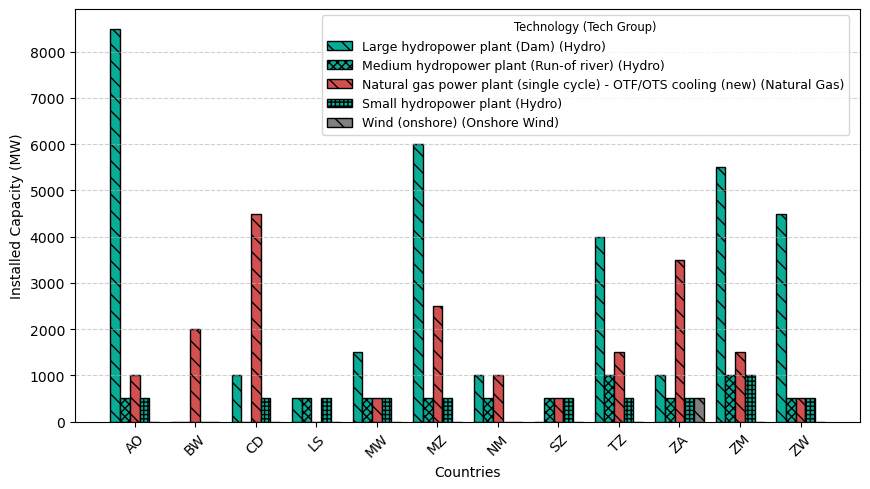

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample aggregation (adjust as needed)
capacity_df.columns = capacity_df.columns.str.replace(' ', '_')
capacity_df['tech_group'] = capacity_df['tech_group'].str.lstrip()
grouped = capacity_df.groupby(['country', 'Description', 'tech_group'])['INSTALLED_CAPACITY'].sum().reset_index()

# Define a color mapping by tech_group
tech_group_colors = {
    'Hydro': '#08ad97',
    'Natural Gas': '#d35050',
    # Add more tech_groups if needed
}

# Define some hatch patterns
hatch_patterns = '\\\\', 'xxxx', '++++', '----', 'oo', '***', '||', '..'

# Prepare figure
fig, ax = plt.subplots(figsize=(9, 5))

countries = grouped['country'].unique()
descriptions = grouped['Description'].unique()
bar_width = 0.8 / len(descriptions)  # Adjust bar width based on number of techs

# Create mapping from tech_group + description to hatch pattern
techs_per_group = grouped.groupby('tech_group')['Description'].unique().to_dict()
tech_hatch_map = {}
for tg, techs in techs_per_group.items():
    for i, tech in enumerate(techs):
        tech_hatch_map[tech] = hatch_patterns[i % len(hatch_patterns)]

# Plot bars
for i, description in enumerate(descriptions):
    data = grouped[grouped['Description'] == description]
    values = []
    for country in countries:
        row = data[data['country'] == country]
        if not row.empty:
            values.append(row['INSTALLED_CAPACITY'].values[0])
        else:
            values.append(0)

    tech_group = data['tech_group'].iloc[0]
    color = tech_group_colors.get(tech_group, 'gray')
    hatch = tech_hatch_map.get(description, '')
    
    x = np.arange(len(countries)) + i * bar_width
    ax.bar(
        x,
        values,
        width=bar_width,
        label=f"{description} ({tech_group})",
        color=color,
        hatch=hatch,
        edgecolor='black'  # Makes hatch visible
    )

# Final touches
ax.set_xticks(np.arange(len(countries)) + bar_width * (len(descriptions) - 1) / 2)
ax.set_xticklabels(countries, rotation=45)
ax.set_xlabel("Countries")
ax.set_ylabel("Installed Capacity (MW)")
#ax.set_title("Installed Capacity by Country and Technology Description")
ax.legend(title="Technology (Tech Group)", loc='upper center', bbox_to_anchor=(0.65, 1.0), ncol=1, fontsize='9', title_fontsize='small')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [10]:
import plotly.express as px

# Prepare the data
grouped = capacity_df.groupby(['tech', 'country', 'Colour'])['INSTALLED_CAPACITY'].sum().reset_index()

color_mapping = {
    ' Hydro': '#08ad97',        
    ' Natural Gas': '#d35050',  # yellow
    # Add more mappings as needed
}

# Create a color mapping from tech to Colour
color_mapping = dict(zip(grouped['tech'], grouped['Colour']))

# Plot the grouped bar chart
fig = px.bar(
    grouped,
    x='country',
    y='INSTALLED_CAPACITY',
    color='tech',
    barmode='group',
    color_discrete_map=color_mapping,
    #title='Installed Capacity by Country and Technology'
)

# Update layout to move the legend above
fig.update_layout(
    xaxis_title='Countries',
    yaxis_title='Installed Capacity (MW)',
    height=300,
    width=600,
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=1.02,  # Position above the plot
        xanchor="center",
        x=0.5
    )
)

fig.show()


In [11]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

# Unique countries from both dataframes
all_countries = capacity_df['country'].unique().tolist()



# Plot the data
for country in capacity_df['country'].unique():
    country_data = capacity_df[capacity_df['country'] == country]
    country_data = country_data[(country_data['INSTALLED_CAPACITY'] != 0) ]

    # Display the filtered data in a nice table format
    #display(country_data[['Description', 'INSTALLED_CAPACITY', 'MIN_INSTALLED_CAPACITY']].round())

    # Create a single plot with two groups of bars
    fig = go.Figure()

    # Add MIN_INSTALLED_CAPACITY bars
    fig.add_trace(
        go.Bar(
            x=country_data['Description'],
            y=country_data['MIN_INSTALLED_CAPACITY'],
            name='Min Installed Capacity',
            marker_color='blue'
        )
    )

    # Add INSTALLED_CAPACITY bars
    fig.add_trace(
        go.Bar(
            x=country_data['Description'],
            y=country_data['INSTALLED_CAPACITY'],
            name='Installed Capacity',
            marker_color='green'
        )
    )

    # Update layout
    fig.update_layout(
        title_text=f"Capacity Comparison for {country}",
        xaxis_title="Technology",
        yaxis_title="Capacity",
        showlegend=True,
        height=300,
        width=900
    )

    fig.show()


In [12]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

# Unique countries from both dataframes
all_countries = capacity_df['country'].unique().tolist()



# Plot the data
for country in capacity_df['country'].unique():
    country_data = capacity_df[capacity_df['country'] == country]
    country_data = country_data[(country_data['INSTALLED_CAPACITY'] != 0)]

    # Display the filtered data in a nice table format
    #display(country_data[['tech_group', 'INSTALLED_CAPACITY', 'MIN_INSTALLED_CAPACITY']].round())

    # Create a single plot with two groups of bars
    fig = go.Figure()

    # Add MIN_INSTALLED_CAPACITY bars
    fig.add_trace(
        go.Bar(
            x=country_data['tech_group'],
            y=country_data['MIN_INSTALLED_CAPACITY'],
            name='Min Installed Capacity',
            marker_color='blue'
        )
    )

    # Add INSTALLED_CAPACITY bars
    fig.add_trace(
        go.Bar(
            x=country_data['tech_group'],
            y=country_data['INSTALLED_CAPACITY'],
            name='Installed Capacity',
            marker_color='green'
        )
    )

    # Update layout
    fig.update_layout(
        title_text=f"Capacity Comparison for {country}",
        xaxis_title="Technology",
        yaxis_title="Capacity",
        showlegend=True,
        height=300,
        width=900
    )

    fig.show()




In [13]:
ratecapacity_df.tech_group.unique()

array([' Hydro', ' Natural Gas'], dtype=object)

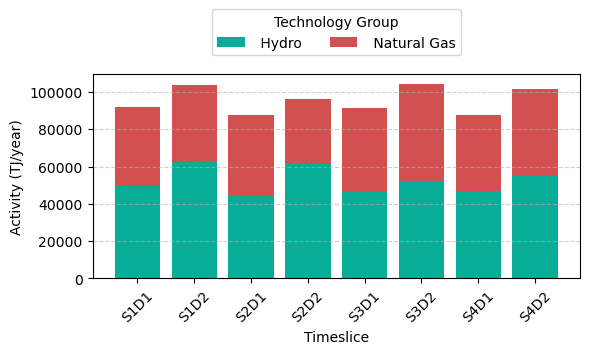

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
grouped = ratecapacity_df.groupby(['timeslice', 'tech_group'])['ACTIVITY'].sum().unstack(fill_value=0)

# Define a custom color mapping for tech_group
color_mapping = {
    ' Hydro': '#08ad97',        
    ' Natural Gas': '#d35050',  # yellow
    # Add more mappings as needed
}

# Assign colors, using 'gray' as fallback
colors = [color_mapping.get(tech_group, 'gray') for tech_group in grouped.columns]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(6, 3))
bottom = np.zeros(len(grouped))

for tech_group, color in zip(grouped.columns, colors):
    ax.bar(grouped.index, grouped[tech_group], label=tech_group, color=color, bottom=bottom)
    bottom += grouped[tech_group]

# Customize the plot
ax.set_xlabel('Timeslice')
ax.set_ylabel('Activity (TJ/year)')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Move the legend above the plot
ax.legend(title='Technology Group', loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)
plt.show()



In [15]:
import plotly.express as px

# Define a color mapping for tech_group
unique_tech_groups = ratecapacity_df['tech_group'].unique()
color_mapping = {tech_group: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
                 for i, tech_group in enumerate(unique_tech_groups)}

# Plot the ACTIVITY for each country
for country in ratecapacity_df['country'].unique():
    country_data = ratecapacity_df[ratecapacity_df['country'] == country]
    
    # Create a bar plot
    fig = px.bar(
        country_data,
        x='Description',
        y='ACTIVITY',
        color='tech_group',
        color_discrete_map=color_mapping,
        title=f"Activity Levels for {country}",
        labels={'ACTIVITY': 'Activity', 'Description': 'Technology'},
        height=400,
        width=900,
    )
    
    fig.update_layout(
        xaxis_title="Technology",
        yaxis_title="Activity",
        showlegend=True
    )
    
    fig.show()

In [16]:
ratecapacity_df

,ANNUAL_POTENTIAL_ACTIVITY,tech,country,Description,Colour,tech_group,mode,timeslice,YEAR_SPLIT,ACTIVITY,ACTIVITY_ROUNDED
4,125000,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro,1,S4D1,0.092466,11558.219178,11363.636364
8,15000,NGGCP04N,AO,Natural gas power plant (single cycle) - OTF/O...,turquoise,Natural Gas,1,S4D1,0.092466,1386.986301,1363.636364
21,105000,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro,1,S2D2,0.157534,16541.095890,17500.000000
24,110000,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro,1,S3D2,0.155822,17140.410959,18333.333333
39,115000,HYDMS03X,AO,Large hydropower plant (Dam),mediumpurple,Hydro,1,S3D1,0.093493,10751.712329,10454.545455
...,...,...,...,...,...,...,...,...,...,...,...
1133,25000,NGGCP04N,NM,Natural gas power plant (single cycle) - OTF/O...,turquoise,Natural Gas,1,S1D1,0.094521,2363.013699,2272.727273
1139,15000,HYDMS03X,NM,Large hydropower plant (Dam),mediumpurple,Hydro,1,S4D2,0.154110,2311.643836,2500.000000
1146,15000,HYDMS03X,NM,Large hydropower plant (Dam),mediumpurple,Hydro,1,S4D1,0.092466,1386.986301,1363.636364
1149,20000,NGGCP04N,NM,Natural gas power plant (single cycle) - OTF/O...,turquoise,Natural Gas,1,S1D2,0.157534,3150.684932,3333.333333


In [17]:
import plotly.express as px
import pandas as pd

# If not already: ensure 'timeslice' is uppercase (e.g., 'S1D1'), and categorical with correct order
timeslice_order = ['S1D1', 'S1D2', 'S2D1', 'S2D2', 'S3D1', 'S3D2', 'S4D1', 'S4D2']  # Adjust as needed
ratecapacity_df['timeslice'] = ratecapacity_df['timeslice'].str.upper()
ratecapacity_df['timeslice'] = pd.Categorical(ratecapacity_df['timeslice'], categories=timeslice_order, ordered=True)

# Create a color mapping for tech_group
color_mapping = {group: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
                 for i, group in enumerate(ratecapacity_df['tech_group'].unique())}

# Generate a stacked bar plot per country
for country in ratecapacity_df['country'].unique():
    country_data = ratecapacity_df[ratecapacity_df['country'] == country]

    fig = px.bar(
        country_data,
        x='timeslice',
        y='ACTIVITY',
        color='tech_group',
        color_discrete_map=color_mapping,
        category_orders={'timeslice': timeslice_order},
        title=f"Activity by Timeslice and Tech Group - {country}",
        labels={'ACTIVITY': 'Activity Level', 'timeslice': 'Timeslice'},
        height=400,
        width=900
    )

    fig.update_layout(
        barmode='stack',
        xaxis_title='Timeslice',
        yaxis_title='Activity',
        showlegend=True
    )

    fig.show()


In [18]:
import plotly.graph_objects as go

# Iterate through each unique country
for country in ratecapacity_df['country'].unique():
    # Filter and group data
    activity_data = ratecapacity_df[ratecapacity_df['country'] == country].groupby('timeslice')['ACTIVITY'].sum().reset_index()
    demand_data = demand_df[demand_df['COUNTRY'] == country].groupby('TIMESLICE')['DEMAND_PER_TIMESLICE'].sum().reset_index()

    # Merge activity and demand into one DataFrame for easier handling
    merged_data = pd.merge(activity_data, demand_data, left_on='timeslice', right_on='TIMESLICE')

    # Create the figure
    fig = go.Figure()

    # Add activity bars
    fig.add_trace(
        go.Bar(
            x=merged_data['timeslice'],
            y=merged_data['ACTIVITY'],
            name='Activity',
            marker_color='blue'
        )
    )

    # Add demand bars
    fig.add_trace(
        go.Bar(
            x=merged_data['timeslice'],
            y=merged_data['DEMAND_PER_TIMESLICE'],
            name='Demand',
            marker_color='orange'
        )
    )

    # Add a horizontal line per timeslice to represent demand level
    for i, row in merged_data.iterrows():
        fig.add_shape(
            type='line',
            x0=i - 0.4, x1=i + 0.4,  # width of the bar group
            y0=row['DEMAND_PER_TIMESLICE'], y1=row['DEMAND_PER_TIMESLICE'],
            line=dict(color='red', width=2, dash='dash'),
            xref='x', yref='y'
        )

    # Layout settings
    fig.update_layout(
        title=f"Activity vs Demand per Timeslice for {country}",
        xaxis_title="Timeslice",
        yaxis_title="Value",
        barmode='group',
        height=400,
        width=800,
        showlegend=True
    )

    fig.show()


/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/945313196.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [19]:
import plotly.graph_objects as go

# Iterate through each unique country
for country in ratecapacity_df['country'].unique():
    # Filter and group data
    activity_data = ratecapacity_df[ratecapacity_df['country'] == country].groupby('timeslice')['ACTIVITY_ROUNDED'].sum().reset_index()
    demand_data = demand_df[demand_df['COUNTRY'] == country].groupby('TIMESLICE')['DEMAND_PER_TIMESLICE'].sum().reset_index()

    # Merge activity and demand into one DataFrame for easier handling
    merged_data = pd.merge(activity_data, demand_data, left_on='timeslice', right_on='TIMESLICE')

    # Create the figure
    fig = go.Figure()

    # Add activity bars
    fig.add_trace(
        go.Bar(
            x=merged_data['timeslice'],
            y=merged_data['ACTIVITY_ROUNDED'],
            name='ACTIVITY_ROUNDED',
            marker_color='blue'
        )
    )

    # Add demand bars
    fig.add_trace(
        go.Bar(
            x=merged_data['timeslice'],
            y=merged_data['DEMAND_PER_TIMESLICE'],
            name='Demand',
            marker_color='orange'
        )
    )

    # Add a horizontal line per timeslice to represent demand level
    for i, row in merged_data.iterrows():
        fig.add_shape(
            type='line',
            x0=i - 0.4, x1=i + 0.4,  # width of the bar group
            y0=row['DEMAND_PER_TIMESLICE'], y1=row['DEMAND_PER_TIMESLICE'],
            line=dict(color='red', width=2, dash='dash'),
            xref='x', yref='y'
        )

    # Layout settings
    fig.update_layout(
        title=f"Activity vs Demand per Timeslice for {country}",
        xaxis_title="Timeslice",
        yaxis_title="Value",
        barmode='group',
        height=400,
        width=800,
        showlegend=True
    )

    fig.show()


/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/var/folders/m8/r27kxds966760lhkksdrvk100000gn/T/ipykernel_3116/3366382334.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

